# Diffraction Studies Automation
written by: Taylor Contreras, Feb 5 2021

This code controls the automation of the oscilliscope and the motors to take measurements of the light intensity of a SiPM. An LED is aligned with a diffraction grating in front of the SiPM. The SiPM and LED are on tracks that can move vertically. This allows the calibration of the SiPM with no light and for the measurement of light intensity as a function of angle from the diffraction grating. 

See other notebooks for more details and tests (PyVisa_tutorial.ipynb, Ardruino_testing.ipynb, Motot_control_testing.ipynb)

In [1]:
from motor import Motor
import oscilliscope as osc
import alignment
import run

import pyvisa
import pyfirmata

#### Connect to the oscilliscope

In [2]:
# Before running, connect the laptop to the oscilloscope through the USBTMC
rm = pyvisa.ResourceManager()
# Use the name this prints to grab the instrument in the next step
rm.list_resources() 

('USB0::0x05FF::0x1023::4206N21552::INSTR',
 'ASRL3::INSTR',
 'ASRL4::INSTR',
 'ASRL10::INSTR')

In [3]:
# Grabs the instrument and prints name
scope = rm.open_resource('USB0::0x05FF::0x1023::4206N21552::INSTR')

#### Connect to the Arduino

In [4]:
# Use Arduino IDE to find the port name
# under Tools->Port
# This time is was COM3
board = pyfirmata.Arduino('COM3') 

In [5]:
# Creat sipm and led motor class objects
sipm_step_pin = 8
sipm_dir_pin = 9
led_step_pin = 10
led_dir_pin = 11
sipm_motor = Motor(board, sipm_step_pin, sipm_dir_pin, 'sipm')
led_motor = Motor(board, led_step_pin, led_dir_pin, 'led')
#sipm_motor.CreatePositionFile()
#led_motor.CreatePositionFile()

#### Global variables

In [6]:
MAX_Z = 231. # Mazimum allowable height in mm
GRATING_LED_POSITION = 70. # LED position for alignment with grating
BELOW_GRATING_LED_POSITION = 67 # LED position for alignment below grating
BELOW_MOUNT_LED_POSITION = 45 # LED position for alignment below grating
SIPM_OFFSET = 13.86 #14.355 # Difference in height between SiPM and LeD for direct alignment. LED is lower.
NUM_SWEEPS = 15

In [7]:
alignment.Align(sipm_motor, led_motor, 'grating')

In [66]:
sipm_motor.SetToZero()
led_motor.SettoZero()

In [51]:
alignment.Align(sipm_motor, led_motor, "below_grating")

In [58]:
osc.MeasurePeaktoPeak()

0.0645624865137506

'150/150'

Saving Global Variables


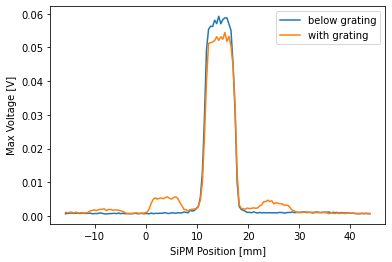

In [68]:
run.Run('run001_distilled_water_data_50ns_15sweeps.csv')

In [ ]:
# Make sure to close the connection (in teh reverse order of setting it up)
scope.close()
rm.close()